In [74]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
from cv2 import xfeatures2d
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [75]:
def load_image(image_path):
    return cv2.imread(image_path)

In [76]:
def statistic():
    label = []
    num_images = []
    for lab in os.listdir('trainingset'):
        label.append(lab)
        num_images.append(len(os.listdir(os.path.join('trainingset', lab))))

    return label, num_images

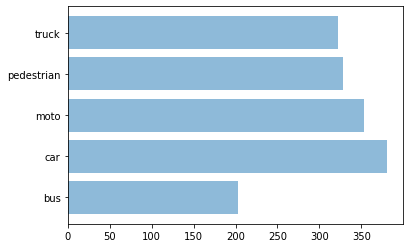

Total images: 1586


In [77]:
label, num_images = statistic()

y_pos = np.arange(len(label))

plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

print('Total images: %d' %(sum(num_images)))

In [78]:
def read_data(label2id):
    X = []
    Y = []

    for label in os.listdir('trainingset'):
        for img_file in os.listdir(os.path.join('trainingset', label)):
        
            img = load_image(os.path.join('trainingset', label, img_file))
            X.append(img)
            Y.append(label2id[label])
    return X, Y

In [79]:
# Label to id, used to convert string label to integer 
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)
print(len(X))
print(len(Y))
print(X[0].shape)
print(Y[0])

1586
1586
(168, 134, 3)
4


In [80]:
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.xfeatures2d.SIFT_create()

    for i in range(len(X)):
        kp, des = sift.detectAndCompute(X[i], None)
    
        image_descriptors.append(des)
        

    return image_descriptors

In [81]:
image_descriptors = extract_sift_features(X)
print(len(image_descriptors))
print(type(image_descriptors[0][0]))
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1586
<class 'numpy.ndarray'>
Image 0 has 109 descriptors
Image 1 has 148 descriptors
Image 2 has 57 descriptors
Image 3 has 29 descriptors
Image 4 has 83 descriptors
Image 5 has 28 descriptors
Image 6 has 219 descriptors
Image 7 has 22 descriptors
Image 8 has 62 descriptors
Image 9 has 181 descriptors


In [82]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 149823


In [83]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []
    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    return bow_dict

In [84]:
num_clusters = 5
if not os.path.isfile('bow_dictionary150.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open('bow_dictionary150.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary150.pkl', 'rb'))
    
print(len(BoW))
print(type(BoW[0]))

5
<class 'numpy.ndarray'>


In [85]:
from scipy.spatial.distance import cdist

In [86]:
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            argmin = np.argmin(distance, axis=1)
            for j in argmin:
                features[j] += 1
        X_features.append(features)


    return X_features

In [87]:
print(image_descriptors[0].shape)
print(BoW[0].shape)
X_features = create_features_bow(image_descriptors, BoW, num_clusters)
print(len(X_features))
print(X_features[0])
print(sum(X_features[0]))
print(image_descriptors[0].shape[0])

(109, 128)
(128,)
1586
[20 37 22 17 13]
109
109


In [88]:
print(len(X_features))
print(len(Y))

1586
1586


In [89]:
from sklearn.model_selection import train_test_split

X_train = [] 
X_test = []
Y_train = []
Y_test = []
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

1268
318


In [90]:
svm = sklearn.svm.SVC(C = 30)
svm.fit(X_train, Y_train)
svm.score(X_train, Y_train)
svm.score(X_test, Y_test)

0.550314465408805

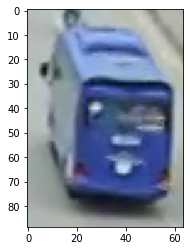

In [91]:
img = load_image('image_test/bus.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

my_X = [img]

In [92]:

my_image_descriptors = extract_sift_features(my_X)
my_X_features = create_features_bow(my_image_descriptors, BoW, num_clusters)

print(len(my_image_descriptors))
print(my_X_features[0].shape)

1
(5,)


In [93]:

y_pred = svm.predict(my_X_features)
print(y_pred)
print(label2id)
# Get your label name using label2id variable (define above)
for key, value in label2id.items():
    if value == y_pred[0]:
        print('Your prediction: ', key)

[3]
{'pedestrian': 0, 'moto': 1, 'truck': 2, 'car': 3, 'bus': 4}
Your prediction:  car
